## Download Vehicle MPG Dataset

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets

# Combine features and target into one DataFrame for easy filtering
data = pd.concat([X, y], axis=1)

# Drop rows where the target variable is NaN
cleaned_data = data.dropna()

# Split the data back into features (X) and target (y)
X = cleaned_data.iloc[:, :-1]
y = cleaned_data.iloc[:, -1]

# Display the number of rows removed
rows_removed = len(data) - len(cleaned_data)
print(f"Rows removed: {rows_removed}")

Rows removed: 6


## Data Splitting and Standardization

In [2]:
from sklearn.model_selection import train_test_split

# Do a 70/30 split (e.g., 70% train, 30% other)
X_train, X_leftover, y_train, y_leftover = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,    # for reproducibility
    shuffle=True,       # whether to shuffle the data before splitting
)

# Split the remaining 30% into validation/testing (15%/15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_leftover, y_leftover,
    test_size=0.5,
    random_state=42,
    shuffle=True,
)

# Compute statistics for X (features)
X_mean = X_train.mean(axis=0)  # Mean of each feature
X_std = X_train.std(axis=0)    # Standard deviation of each feature

# Standardize X
X_train = ((X_train - X_mean) / X_std).to_numpy()
X_val = ((X_val - X_mean) / X_std).to_numpy()
X_test = ((X_test - X_mean) / X_std).to_numpy()

# Compute statistics for y (targets)
y_mean = y_train.mean()  # Mean of target
y_std = y_train.std()    # Standard deviation of target

# Standardize y
y_train = ((y_train - y_mean) / y_std).to_numpy().reshape(-1, 1)
y_val = ((y_val - y_mean) / y_std).to_numpy().reshape(-1, 1)
y_test = ((y_test - y_mean) / y_std).to_numpy().reshape(-1, 1)

In [3]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((274, 7), (274, 1), (59, 7), (59, 1), (59, 7), (59, 1))

Epoch 1  :::  Train Loss=0.6576738884748433  :::  Val Loss=0.5297489042118871
Epoch 2  :::  Train Loss=0.5634623006870645  :::  Val Loss=0.4646440650733828
Epoch 3  :::  Train Loss=0.4957686651957627  :::  Val Loss=0.40987246441974345
Epoch 4  :::  Train Loss=0.4384864460767591  :::  Val Loss=0.3614047931885294
Epoch 5  :::  Train Loss=0.3876003403173726  :::  Val Loss=0.31651477386035637
Epoch 6  :::  Train Loss=0.3418633203133  :::  Val Loss=0.27709994398806315
Epoch 7  :::  Train Loss=0.30063627550225547  :::  Val Loss=0.24207240769221086
Epoch 8  :::  Train Loss=0.2640948786036832  :::  Val Loss=0.21236113339522053
Epoch 9  :::  Train Loss=0.23239534354965807  :::  Val Loss=0.1868700485696329
Epoch 10  :::  Train Loss=0.20525651024104688  :::  Val Loss=0.16508198751578826
Epoch 11  :::  Train Loss=0.18267738322098814  :::  Val Loss=0.147256528049325
Epoch 12  :::  Train Loss=0.16451847777304407  :::  Val Loss=0.13281619931543048
Epoch 13  :::  Train Loss=0.14958979381281542  :::  V

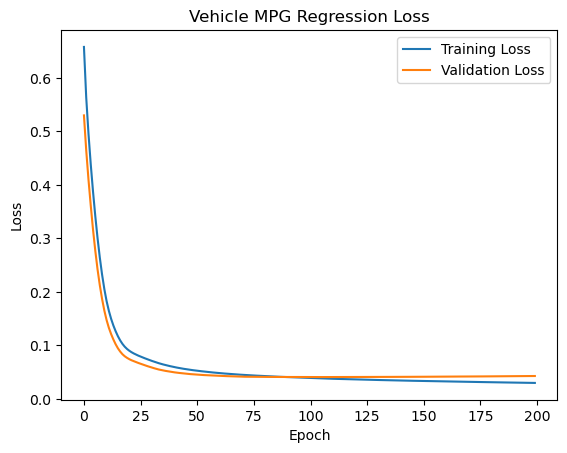

In [91]:
from MLP import MultilayerPerceptron, Layer, Relu, SquaredError, Linear, Mish, Tanh, Sigmoid
import matplotlib.pyplot as plt

mlp = MultilayerPerceptron([
    Layer(fan_in=X_train.shape[1], fan_out=100, activation_function=Relu(), dropout_rate=0),
    Layer(fan_in=100, fan_out=60, activation_function=Relu(), dropout_rate=0),
    Layer(fan_in=60, fan_out=25, activation_function=Relu(), dropout_rate=0),
    Layer(fan_in=25, fan_out=1, activation_function=Linear(), dropout_rate=0)
])

# Train the model using RMSProp.
training_losses, validation_losses = mlp.train(
    train_x=X_train,
    train_y=y_train, 
    val_x=X_val,
    val_y=y_val,     
    loss_func=SquaredError(),
    learning_rate=1E-4,
    batch_size=32,
    epochs=200,
    use_rmsprop=True,
    decay_rate=0.9,
    epsilon=1e-8
)

# Plot training and validation losses.
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Vehicle MPG Regression Loss")
plt.legend()
plt.show()


Total Testing Loss: 0.047673162644858484


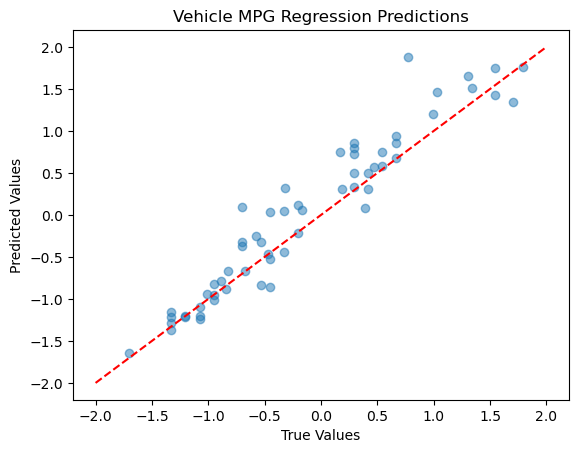

In [92]:
import random

y_test_pred = mlp.forward(X_test, training=False)

test_loss = SquaredError().loss(y_test, y_test_pred)
print(f"Total Testing Loss: {test_loss}")

# Plot the predicted vs. true values.
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([-2, 2], [-2, 2], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Vehicle MPG Regression Predictions")
plt.show()



In [86]:
indices = random.sample(range(X_test.shape[0]), 10)
# Get the corresponding test inputs and actual outputs
X_sample = X_test[indices]
mpg_actual = y_test[indices] * y_std + y_mean
mpg_pred = mlp.forward(X_sample) * y_std + y_mean
print("Sample\tPredicted MPG\tActual MPG")
for i, idx in enumerate(indices):
    print(f"{idx}\t{mpg_pred[i,0]:.2f}\t\t{mpg_actual[i,0]:.2f}")
# mlp.forward(X_test[:10], training=False)* y_std + y_mean, y_test[:10] * y_std + y_mean

Sample	Predicted MPG	Actual MPG
22	19.15		16.50
36	24.62		26.80
1	16.64		16.00
5	17.11		19.40
14	37.98		36.00
55	30.57		26.00
25	16.86		16.90
48	9.92		10.00
3	13.33		13.00
13	21.51		18.00
